In [1]:
# import logging
import os
import re
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import torch
import yaml
from einops import rearrange

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mushroom.mushroom_v2 import Mushroom
import mushroom.utils as utils

/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packag

In [5]:
run_dir = '/data/estorrs/mushroom/data/projects/subclone'
mushroom_dir = os.path.join(run_dir, 'mushroom')
config_fps = sorted(utils.listfiles(mushroom_dir, regex=r'/config.yaml'))
config_fps

['/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT206B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT225C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT226C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT235B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT243B1-H3/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT243B1-H4/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT268B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT271B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT339B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT413C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclon

In [6]:
# only relavent for dinglab data since our channel names are all over the place
# will remove for official example
official_to_options = {
    'Pan-Cytokeratin': ['Pan-Cytokeratin', 'Pan-CK', 'Pan-CK (D)', 'PanCK (D)'],
    'E-cadherin': ['E-cadherin'],
    'CD45': ['CD45 (D)', 'CD45', 'CD45-(D)'],
    'CD45RO': ['CD45RO'],
    'CD45RA': ['CD45RA'],
    'CD8': ['CD8', 'CD8a'],
    'DAPI': ['DAPI'],
    'CD4': ['CD4', 'CD4 (D)'],
    'CD3e': ['CD3e', 'CD3'],
    'Vimentin': ['Vimentin-(D)', 'Vimentin', 'Vimentin (D)'],
    'SMA': ['SMA-(D)', 'SMA', 'SMA (D)', 'a-SMA (D)'],
    'CD31': ['CD31', 'CD31-(D)', 'CD31 (D)'],
    'CD20': ['CD20-(D)', 'CD20', 'CD20 (D)', 'CD20-Akoya'],
    'CD68': ['CD68', 'CD68 (D)', 'CD68-(D)'],
    'CD163': ['CD163'],
    'FOXP3': ['FoxP3', 'FOXP3', 'Foxp3'],
    'cKit': ['cKIT (D)', 'cKit (D)', 'cKit', 'cKIT', 'cKIT-(D)'],
    'MGP': ['MGP', 'MGP (D)', 'MGP-(D)'],
    'CD36': ['CD36-(D)', 'CD36'],
    'PR': ['PR', 'PR-(D)', 'PR (D)'],
    'ER': ['ER', 'ER-(D)', 'ER (D)'],
    'P21': ['P21', 'P21-(D)', 'P21-(D)', 'P21 (D)'],
    'P16': ['P16-(D)'],
    'CK5': ['Keratin 5', 'KRT5'],
    'TFF1': ['TFF1', 'TFF1-(D)', 'TFF1 (D)'],
    'beta-integrin': ['beta-integrin', 'beta3-integrin'],
    'CK14': ['CK14', 'Keratin 14', 'CK14 (D)'],
    'CK17': ['CK17', 'CK17 (D)', 'CK17-(D)', 'Keratin 17'],
    'CK19': ['CK19', 'CK19 (D)', 'CK19-(D)'],
    'CD11b': ['CD11b', 'CD11b (D)', 'CD11b-(D)'],
    'GATA3': ['GATA3', 'GATA3-(D)', 'GATA3 (D)'],
    'PLAT/tPA': ['PLAT/tPA', 'PLAT/tPA (D)'],
    'COX6c': ['COX6c (D)'],
    'Her2': ['Her2', 'Her2 (D)'],
    'Bap1': ['Bap1 (D)'],
    'GLUT1': ['Glut1', 'GLUT1', 'GLUT1-(D)', 'GLUT1 (D)'],
    'CD11c': ['CD11c'],
    'HLA-DR': ['HLA-DR'],
    'Ki67': ['Ki67', 'KI67'],
    'Podoplanin': ['Podoplanin', 'PDPN', 'Podoplanin (D)'],
    'CTLA4': ['CTLA4', 'CTLA4 (D)', 'CTLA4-(D)'],
    'SLC39A6': ['SLC39A6'],
    'BCA1': ['BCA1'],
    'BCAL': ['BCAL'],
    'TUBB3': ['TUBB3', 'TUBB3 (D)'],
    'PTPRZ1': ['PTPRZ1', 'PTPRZ1 (D)'],
    'HIF1A': ['HIF1a', 'HIF1a (D)', 'HIF1A'],
    'PAI1': ['PAI1', 'PAI1-(D)'],
    'GFAP': ['GFAP', 'GFAP (D)'],
    'VEGFA': ['VEGFA', 'VEGFA (D)'],
    'IBA1': ['IBA1', 'IBA1 (D)'],
    'OLIG2': ['OLIG2', 'OLIG2 (D)'],
    'FN1': ['FN1', 'FN1 (D)'],
    'a-Amylase': ['a-Amylase'],
    'Hep-Par-1': ['Hep-Par-1 (D)'],
    'Granzyme-B': ['Granzyme B'],
    'TCF-1': ['TCF-1'],
    'CD39': ['CD39'],
    'PD1': ['PD-1'],
    'PDL1': ['PD-L1'],
    'Histone-H3-Pho': ['Histone H3 Pho'],
    'Maspin': ['Maspin'],
    'MMP9': ['MMP9'],
    'CD44': ['CD44'],
    'CD107A': ['CD107a'],
    'FGFR3': ['FGFR3'],
    'CD138': ['CD138'],
    'MLPH': ['MLPH'],
    'P63': ['P63'],
    'GP2': ['GP2'],
    'COX2': ['COX2'],
    'Lyve-1': ['Lyve-1'],
}
channel_mapping = {v:k for k, vs in official_to_options.items() for v in vs}
# channel_mapping = None

In [11]:
visium_config = {
    'dtype': 'multiplex',
#     'sections': config,
    'chkpt_filepath': None,
    'sae_kwargs': {
        'size': 256,
        'patch_size': 32,
        'encoder_dim': 256,
        'kl_scaler': .001,
        'recon_scaler': 1.,
        'neigh_scaler': 1.,
        'codebook_size': 100,
        'decoder_dims': (256, 100, 30,)
    },
    'learner_kwargs': {
        'scale': .1,
        'contrast_pct': None,
#         'pct_expression': .02,
        'batch_size': 64,
        'num_workers': 1,
        'device': 'cpu',
#         'channels': channels,
        'channel_mapping': channel_mapping
    },
    'train_kwargs': {
        'num_iters': 10000,
        'lr': 1e-4,
        'log_every': 10,
        'save_every': 500,
#         'save_dir': chkpt_dir       
    },
    'cluster_kwargs': {
        'num_clusters': 20,
        'mask_background': True,
        'margin': .05,
        'background_channels': None,
        'span_all_sections': True,
        'centroids': None,
    }
}

In [140]:
config_fp = '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1/config.yaml'

case = config_fp.split('/')[-2]
out_dir = os.path.join(f'/data/estorrs/mushroom/data/projects/testing/mushroom/{case}_vae_vq_codex/outputs')

config = yaml.safe_load(open(config_fp))

chkpt_dir = os.path.join(out_dir, 'chkpts')
Path(chkpt_dir).mkdir(parents=True, exist_ok=True)

In [364]:
visium_config['sections'] = config
visium_config['train_kwargs']['save_dir'] = chkpt_dir
visium_config['chkpt_filepath'] = os.path.join(chkpt_dir, '5500iter.pt')

In [365]:
mushroom = Mushroom.from_config(visium_config)

INFO:root:using device: cpu
INFO:root:generating inputs for multiplex tissue sections
INFO:root:using 24 channels
INFO:root:4 sections detected: ['s1', 's2', 's4', 's5']
INFO:root:processing sections
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:learner initialized
INFO:root:initializing clusterer


In [366]:
mushroom.learner.sae.vq.codebook.shape

torch.Size([100, 256])

In [367]:
mushroom.embed_sections()

array([[<Axes: title={'center': 's1'}, ylabel='predicted'>,
        <Axes: title={'center': 's2'}>, <Axes: title={'center': 's4'}>,
        <Axes: title={'center': 's5'}>],
       [<Axes: ylabel='true'>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

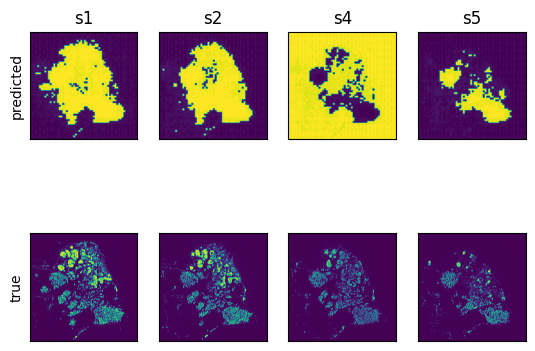

In [368]:
mushroom.display_predicted_pixels(channel='Pan-Cytokeratin')

array([[<Axes: title={'center': 's1'}, ylabel='predicted'>,
        <Axes: title={'center': 's2'}>, <Axes: title={'center': 's4'}>,
        <Axes: title={'center': 's5'}>],
       [<Axes: ylabel='true'>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

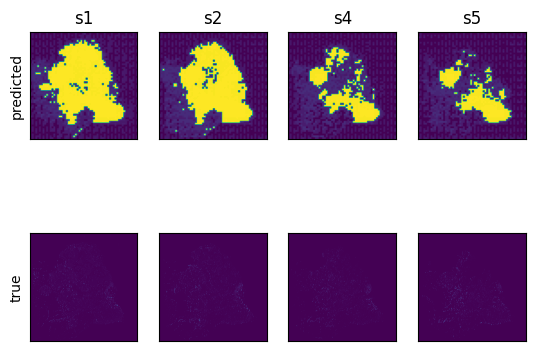

In [369]:
mushroom.display_predicted_pixels(channel='CD31')

array([[<Axes: title={'center': 's1'}, ylabel='predicted'>,
        <Axes: title={'center': 's2'}>, <Axes: title={'center': 's4'}>,
        <Axes: title={'center': 's5'}>],
       [<Axes: ylabel='true'>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

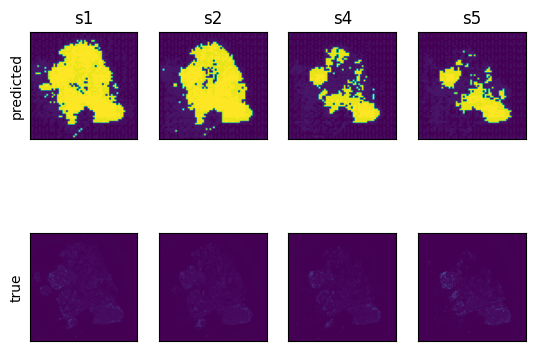

In [370]:
mushroom.display_predicted_pixels(channel='CD45')

array([[<Axes: title={'center': 's1'}, ylabel='predicted'>,
        <Axes: title={'center': 's2'}>, <Axes: title={'center': 's4'}>,
        <Axes: title={'center': 's5'}>],
       [<Axes: ylabel='true'>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

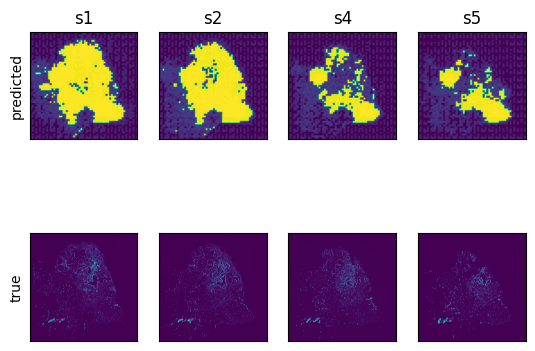

In [371]:
mushroom.display_predicted_pixels(channel='SMA')

In [372]:
# cluster_ids = mushroom.recon_cluster_probs.argmax(dim=1).cpu().detach().numpy()
cluster_ids = mushroom.recon_cluster_ids.cpu().detach().numpy().astype(int)

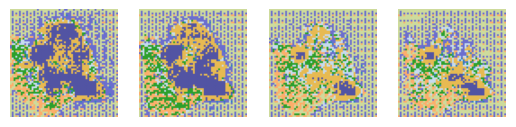

In [373]:
from mushroom.visualization.utils import display_labeled_as_rgb
cmap = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c') + sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')
fig, axs = plt.subplots(ncols=len(cluster_ids))
for ax, x in zip(axs, cluster_ids):
    x = display_labeled_as_rgb(x, cmap=cmap)
    ax.imshow(x)
    ax.axis('off')

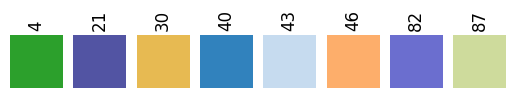

In [374]:
labels = np.unique(cluster_ids)
fig, axs = plt.subplots(ncols=len(labels))
for n, l in enumerate(labels):
    axs[n].imshow(rearrange(np.asarray(cmap[l]), 'n -> 1 1 n'))
    axs[n].axis('off')
    axs[n].set_title(str(l), rotation=90)
    

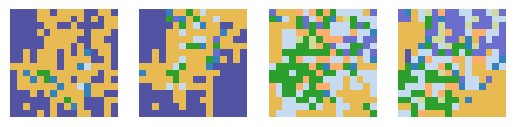

In [375]:
from mushroom.visualization.utils import display_labeled_as_rgb
cmap = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c') + sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')
fig, axs = plt.subplots(ncols=len(cluster_ids))
for ax, x in zip(axs, cluster_ids):
    x = display_labeled_as_rgb(x[20:36, 20:36], cmap=cmap)
    ax.imshow(x)
    ax.axis('off')

In [376]:
import torch.nn.functional as F

In [377]:
x = rearrange(mushroom.recon_embs, 'n c h w -> n h w c')
codebook = mushroom.learner.sae.vq.codebook
dists = torch.zeros(x.shape[0], x.shape[1], x.shape[2], codebook.shape[0])
for n in range(x.shape[0]):
    for h in range(x.shape[1]):
        for w in range(x.shape[2]):
            for c in range(codebook.shape[0]):
                dists[n, h, w, c] = F.cosine_similarity(x[n, h, w], codebook[c], dim=0)
dists.shape

torch.Size([4, 60, 60, 100])

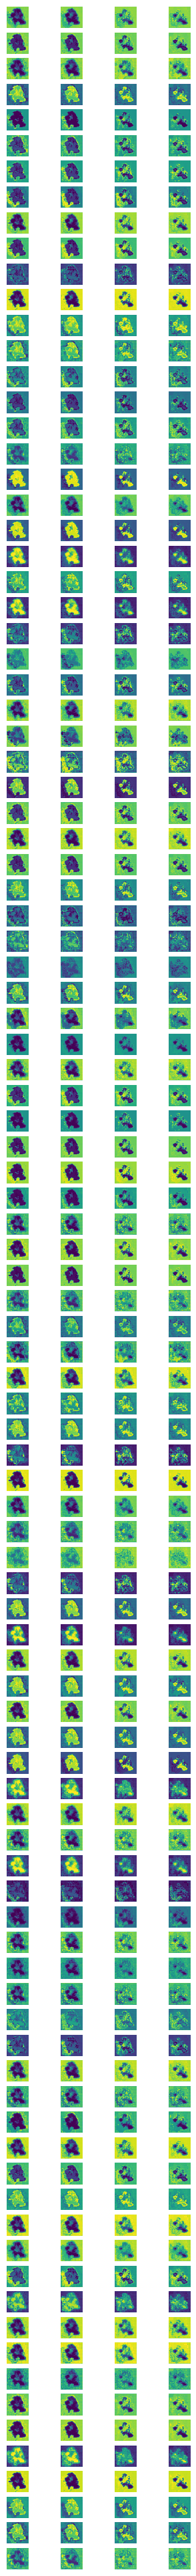

In [378]:
fig, axs = plt.subplots(nrows=dists.shape[-1], ncols=dists.shape[0], figsize=(4, 50))
for c in range(dists.shape[0]):
    for r in range(dists.shape[-1]):
        ax = axs[r, c]
        ax.imshow(dists[c, ..., r])
        ax.axis('off')
        ax.set_ylabel(r, rotation=90)

In [379]:
# fig, axs = plt.subplots(nrows=dists.shape[-1], ncols=dists.shape[0], figsize=(3, 25))
# for c in range(dists.shape[0]):
#     for r in range(dists.shape[-1]):
#         ax = axs[r, c]
#         ax.imshow(dists[c, ..., r])
#         ax.axis('off')

In [380]:
mushroom.recon_imgs.shape

torch.Size([4, 24, 60, 60])

In [354]:
from scipy.stats import spearmanr, pearsonr

In [355]:
import torchvision.transforms.functional as TF

distances = rearrange(dists, 'n h w c -> n c h w')

patch_size = 32
exp = TF.resize(
    mushroom.true_imgs,
    (distances.shape[-2], distances.shape[-1]),
    antialias=False,
).numpy()
exp.shape

(4, 24, 60, 60)

In [356]:
data = []

for i, channel in enumerate(mushroom.learner.channels):
    y = exp[:, i].flatten()
    row = []
    for j in range(distances.shape[1]):
        x = distances[:, j].flatten()
        corr, pval = spearmanr(x, y)
        row.append(corr)
    data.append(row)

df = pd.DataFrame(data=data, index=mushroom.learner.channels, columns=list(range(distances.shape[1])))
df = df.transpose()
df


,Bap1,CD31,CD45,CD68,CD8,CK14,CK19,COX6c,DAPI,ER,...,Her2,Ki67,MGP,PLAT/tPA,PR,Pan-Cytokeratin,Podoplanin,SMA,Vimentin,cKit
0,-0.205150,-0.551573,-0.487380,-0.395279,0.123357,0.180797,-0.439788,-0.455270,-0.581355,-0.581072,...,-0.428447,-0.353897,-0.472459,-0.579466,-0.573852,-0.544221,-0.078248,-0.472987,-0.537680,-0.033043
1,-0.238054,-0.522155,-0.542468,-0.387149,0.004207,0.128299,-0.459199,-0.458864,-0.505448,-0.544681,...,-0.415711,-0.350061,-0.486716,-0.523279,-0.490972,-0.497690,-0.158565,-0.425343,-0.408182,-0.117550
2,-0.261711,-0.661460,-0.615042,-0.438839,0.127312,0.153808,-0.605755,-0.564768,-0.755050,-0.663059,...,-0.478255,-0.445608,-0.632745,-0.719991,-0.704566,-0.750828,-0.097760,-0.618052,-0.689018,-0.086073
3,0.214040,0.414511,0.453905,0.368950,0.058981,-0.066362,0.431570,0.403272,0.306957,0.471102,...,0.373723,0.282848,0.364663,0.373100,0.268255,0.385401,0.202572,0.303650,0.191681,0.168183
4,-0.198795,-0.419834,-0.382053,-0.355991,0.041498,0.113071,-0.368262,-0.374828,-0.328136,-0.467917,...,-0.378792,-0.278235,-0.322746,-0.387862,-0.320781,-0.362385,-0.114378,-0.314382,-0.268720,-0.085128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.217565,0.615928,0.564639,0.372358,-0.149738,-0.173360,0.516024,0.504577,0.744167,0.601115,...,0.415638,0.410646,0.597657,0.693945,0.728473,0.683246,0.049901,0.591054,0.709765,0.033854
96,-0.179096,-0.374029,-0.396644,-0.378484,-0.053423,0.082632,-0.385863,-0.367571,-0.230494,-0.463137,...,-0.372592,-0.249601,-0.293014,-0.314832,-0.202611,-0.317312,-0.203330,-0.235943,-0.115869,-0.160131
97,0.177292,0.323068,0.338275,0.337856,0.047931,-0.047490,0.364158,0.321717,0.215015,0.395976,...,0.335184,0.218378,0.260584,0.269480,0.154471,0.318994,0.184002,0.207695,0.098510,0.156816
98,0.171049,0.336601,0.288398,0.287345,-0.048587,-0.100826,0.271417,0.292565,0.243946,0.370710,...,0.315989,0.224147,0.239039,0.300664,0.253614,0.260767,0.073426,0.241087,0.206875,0.054116


In [357]:
df.sort_values('CD31', ascending=False)

,Bap1,CD31,CD45,CD68,CD8,CK14,CK19,COX6c,DAPI,ER,...,Her2,Ki67,MGP,PLAT/tPA,PR,Pan-Cytokeratin,Podoplanin,SMA,Vimentin,cKit
21,0.268033,0.679428,0.633116,0.440584,-0.132704,-0.164003,0.607465,0.575435,0.777777,0.674258,...,0.484895,0.458125,0.651572,0.741918,0.738165,0.757711,0.091877,0.636309,0.716424,0.079468
63,0.250929,0.663085,0.604177,0.424897,-0.148828,-0.182695,0.559365,0.550415,0.759326,0.659486,...,0.470614,0.439394,0.620795,0.726601,0.737474,0.713869,0.072401,0.617905,0.714971,0.047595
72,0.257326,0.660988,0.612239,0.435482,-0.132238,-0.163630,0.590313,0.558668,0.759395,0.662064,...,0.476202,0.442101,0.629677,0.721651,0.715477,0.741199,0.092350,0.615756,0.696949,0.074628
23,0.259400,0.655017,0.597741,0.433652,-0.137811,-0.159379,0.587046,0.556283,0.734236,0.656127,...,0.476227,0.441350,0.613856,0.708982,0.696273,0.724804,0.084346,0.609015,0.680013,0.074478
95,0.217565,0.615928,0.564639,0.372358,-0.149738,-0.173360,0.516024,0.504577,0.744167,0.601115,...,0.415638,0.410646,0.597657,0.693945,0.728473,0.683246,0.049901,0.591054,0.709765,0.033854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,-0.251224,-0.660696,-0.600641,-0.427644,0.148126,0.182729,-0.557831,-0.548317,-0.754690,-0.659332,...,-0.473114,-0.437472,-0.616262,-0.721951,-0.731156,-0.711377,-0.074063,-0.612345,-0.708058,-0.048865
2,-0.261711,-0.661460,-0.615042,-0.438839,0.127312,0.153808,-0.605755,-0.564768,-0.755050,-0.663059,...,-0.478255,-0.445608,-0.632745,-0.719991,-0.704566,-0.750828,-0.097760,-0.618052,-0.689018,-0.086073
86,-0.262490,-0.662653,-0.610309,-0.428328,0.133533,0.179204,-0.556901,-0.555620,-0.721959,-0.658044,...,-0.477819,-0.445778,-0.612873,-0.711874,-0.717393,-0.680931,-0.078214,-0.606034,-0.678220,-0.060647
87,-0.261460,-0.662806,-0.603391,-0.432828,0.143502,0.169069,-0.579165,-0.557470,-0.744992,-0.659693,...,-0.479538,-0.446424,-0.620124,-0.718519,-0.717071,-0.721069,-0.077172,-0.614732,-0.694896,-0.066383


In [358]:
df.sort_values('CD31', ascending=False)

,Bap1,CD31,CD45,CD68,CD8,CK14,CK19,COX6c,DAPI,ER,...,Her2,Ki67,MGP,PLAT/tPA,PR,Pan-Cytokeratin,Podoplanin,SMA,Vimentin,cKit
21,0.268033,0.679428,0.633116,0.440584,-0.132704,-0.164003,0.607465,0.575435,0.777777,0.674258,...,0.484895,0.458125,0.651572,0.741918,0.738165,0.757711,0.091877,0.636309,0.716424,0.079468
63,0.250929,0.663085,0.604177,0.424897,-0.148828,-0.182695,0.559365,0.550415,0.759326,0.659486,...,0.470614,0.439394,0.620795,0.726601,0.737474,0.713869,0.072401,0.617905,0.714971,0.047595
72,0.257326,0.660988,0.612239,0.435482,-0.132238,-0.163630,0.590313,0.558668,0.759395,0.662064,...,0.476202,0.442101,0.629677,0.721651,0.715477,0.741199,0.092350,0.615756,0.696949,0.074628
23,0.259400,0.655017,0.597741,0.433652,-0.137811,-0.159379,0.587046,0.556283,0.734236,0.656127,...,0.476227,0.441350,0.613856,0.708982,0.696273,0.724804,0.084346,0.609015,0.680013,0.074478
95,0.217565,0.615928,0.564639,0.372358,-0.149738,-0.173360,0.516024,0.504577,0.744167,0.601115,...,0.415638,0.410646,0.597657,0.693945,0.728473,0.683246,0.049901,0.591054,0.709765,0.033854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,-0.251224,-0.660696,-0.600641,-0.427644,0.148126,0.182729,-0.557831,-0.548317,-0.754690,-0.659332,...,-0.473114,-0.437472,-0.616262,-0.721951,-0.731156,-0.711377,-0.074063,-0.612345,-0.708058,-0.048865
2,-0.261711,-0.661460,-0.615042,-0.438839,0.127312,0.153808,-0.605755,-0.564768,-0.755050,-0.663059,...,-0.478255,-0.445608,-0.632745,-0.719991,-0.704566,-0.750828,-0.097760,-0.618052,-0.689018,-0.086073
86,-0.262490,-0.662653,-0.610309,-0.428328,0.133533,0.179204,-0.556901,-0.555620,-0.721959,-0.658044,...,-0.477819,-0.445778,-0.612873,-0.711874,-0.717393,-0.680931,-0.078214,-0.606034,-0.678220,-0.060647
87,-0.261460,-0.662806,-0.603391,-0.432828,0.143502,0.169069,-0.579165,-0.557470,-0.744992,-0.659693,...,-0.479538,-0.446424,-0.620124,-0.718519,-0.717071,-0.721069,-0.077172,-0.614732,-0.694896,-0.066383


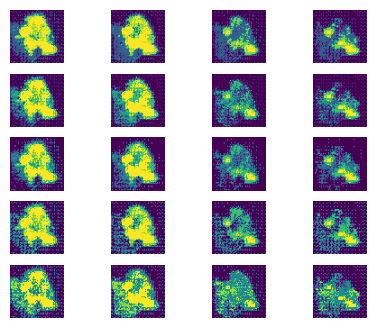

In [359]:
clusters = df.sort_values('CD31', ascending=False).index.to_list()[:5]
fig, axs = plt.subplots(nrows=len(clusters), ncols=distances.shape[0], figsize=(5, 4))
for i, cluster in enumerate(clusters):
    for j in range(distances.shape[0]):
        ax = axs[i, j]
#         ax.imshow(exp[j, mushroom.learner.channels.index('CD31')])
        ax.imshow(distances[j, cluster])
        ax.axis('off')

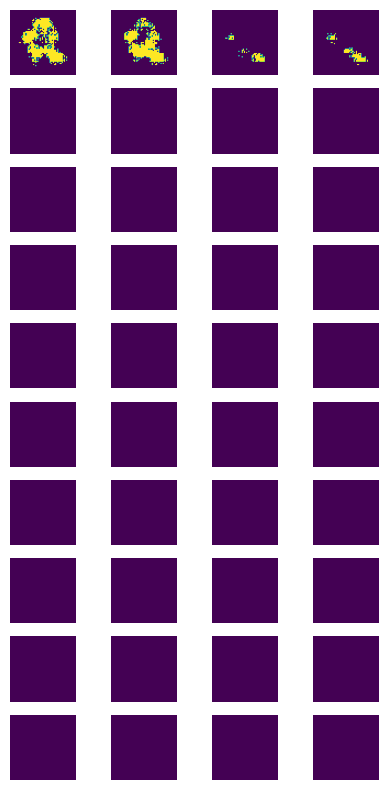

In [360]:
clusters = df.sort_values('CD31', ascending=False).index.to_list()[:10]
fig, axs = plt.subplots(nrows=len(clusters), ncols=cluster_ids.shape[0], figsize=(5, 10))
for i, cluster in enumerate(clusters):
    for j in range(cluster_ids.shape[0]):
        ax = axs[i, j]
#         ax.imshow(exp[j, mushroom.learner.channels.index('CD31')])
        ax.imshow(cluster_ids[j]==cluster)
        ax.axis('off')

In [361]:
distances.shape

torch.Size([4, 100, 60, 60])

In [362]:
# cluster based on cos emb

from sklearn.cluster import AgglomerativeClustering
dist = 20.
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=dist).fit(
    rearrange(distances, 'n c h w -> (n h w) c')
)
# clustering = AgglomerativeClustering(n_clusters=10, distance_threshold=None).fit(exp.values)
cluster_to_label = {c:l for c, l in zip(rearrange(cluster_ids, 'n h w -> (n h w)'), clustering.labels_)}
neigh_ids = np.vectorize(cluster_to_label.get)(cluster_ids)
len(np.unique(neigh_ids))

1

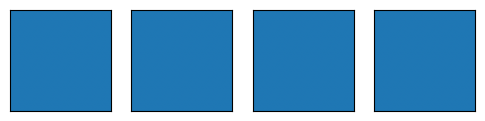

In [363]:
fig, axs = plt.subplots(ncols=neigh_ids.shape[0], figsize=(6, 4))
for i, labeled in enumerate(neigh_ids):
    axs[i].imshow(display_labeled_as_rgb(labeled, cmap=cmap))
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [69]:
counts = Counter(cluster_ids.flatten())

In [70]:
[counts[c] for c in clusters]

[17, 9, 6, 95, 99]

In [73]:
cluster_ids.shape

(4, 60, 60)

In [52]:
F.cosine_similarity(
    torch.rand(256),
    torch.rand(20, 256)
).shape

torch.Size([20])

In [48]:
F.cosine_similarity(x[...], codebook, dim=-1)

RuntimeError: The size of tensor a (60) must match the size of tensor b (40) at non-singleton dimension 2

In [39]:
import torch.nn.functional as F

In [45]:
x[n, h, w].shape, codebook[c].shape

(torch.Size([256]), torch.Size([256]))

In [ ]:
F.cosine_similarity()

In [67]:
mushroom.learner.sae.scale_factors(torch.tensor([0, 1, 2, 3]))[:, mushroom.learner.channels.index('CD45')]

tensor([ 1.6012, -0.7417,  2.3597,  0.6643], grad_fn=<SelectBackward0>)

In [152]:
ds = mushroom.learner.inference_ds

imgs = []
for idx in range(len(ds)):
    section_idx, row_idx, col_idx = ds.idx_to_coord[idx]
    section = ds.sections[section_idx]
    img = ds.section_to_tiles[section][row_idx, col_idx]
    imgs.append(img)
imgs = torch.stack(imgs)

recon_labeled = torch.stack(
    [ds.section_from_tiles(
        imgs, i,
#         size=(mushroom.learner.train_transform.output_size[0], mushroom.learner.train_transform.output_size[1])
    ) for i in range(len(ds.sections))]
)

In [153]:
with torch.no_grad():
    h, w = mushroom.recon_embs.shape[-2], mushroom.recon_embs.shape[-1]
    _, indices, _ = mushroom.learner.sae.vq(
        rearrange(mushroom.recon_embs.to(mushroom.learner.device), 'n d h w -> n (h w) d'))
    indices = rearrange(indices, 'n (h w) -> n h w', h=h, w=w).detach().cpu().numpy()

In [154]:
indices.shape

(4, 60, 60)

In [155]:
def relabel(labels):
    new = np.zeros_like(labels, dtype=labels.dtype)
    ids = np.unique(labels)
    for i in range(len(ids)):
        new[labels==ids[i]] = i
        
    return new

cluster_ids = relabel(indices)
cluster_ids.shape

(4, 60, 60)

In [156]:
np.unique(cluster_ids)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [157]:
import torchvision.transforms.functional as TF
patch_size = 32
resized_cluster_ids = TF.resize(
    torch.tensor(cluster_ids),
    (recon_labeled.shape[-2], recon_labeled.shape[-1]),
    antialias=False,
    interpolation=TF.InterpolationMode.NEAREST
).numpy()
resized_cluster_ids.shape

(4, 1920, 1920)

In [158]:
exp = []
ids = np.unique(cluster_ids)
for i in ids:
#     mask = cluster_ids == int(i)
    mask = resized_cluster_ids == int(i)
#     x = rearrange(mushroom.recon_imgs, 'n d h w -> d n h w')
    x = rearrange(mushroom.true_imgs, 'n d h w -> d n h w')
    exp.append(x[:, mask].mean(-1))

    
exp = torch.stack(exp)
exp = pd.DataFrame(data=exp.numpy(), columns=mushroom.learner.channels, index=ids)
exp = exp[~pd.isnull(exp.iloc[:, 0])]
exp


,Bap1,CD31,CD45,CD68,CD8,CK14,CK19,COX6c,DAPI,ER,...,Her2,Ki67,MGP,PLAT/tPA,PR,Pan-Cytokeratin,Podoplanin,SMA,Vimentin,cKit
0,0.135653,0.060309,0.196396,0.084181,0.013518,0.598725,0.195443,0.215644,0.444009,0.125297,...,0.095422,0.034396,0.549867,0.322370,0.230392,0.335231,0.052833,0.265551,0.286387,0.300481
1,0.102662,0.173230,0.313449,0.315419,0.014049,0.274893,0.272267,0.569661,0.479456,0.263666,...,0.165185,0.061895,0.556276,0.542538,0.306345,0.359909,0.240782,0.338380,0.344366,0.243293
2,0.214952,0.086508,0.438146,0.121400,0.039791,0.314652,0.387735,0.349714,0.633796,0.299786,...,0.233972,0.081543,0.602326,0.489407,0.410037,0.528037,0.050058,0.116576,0.319623,0.362398
3,0.022327,0.032272,0.055813,0.011232,0.013195,0.341353,0.022897,0.041572,0.203219,0.020234,...,0.015059,0.007722,0.209161,0.082997,0.137239,0.045026,0.040476,0.085965,0.160596,0.086382
4,0.256484,0.110080,0.410596,0.186311,0.034289,0.079270,0.329909,0.281702,0.535213,0.108658,...,0.121026,0.072120,0.468117,0.402524,0.285144,0.390914,0.034853,0.217675,0.285680,0.142077
5,0.038013,0.337285,0.320056,0.039905,0.052600,0.031877,0.009616,0.107503,0.552326,0.149213,...,0.063098,0.008852,0.479800,0.413995,0.210459,0.028443,0.123138,0.179513,0.679011,0.028706
6,0.062572,0.164464,0.509942,0.090697,0.132576,0.128912,0.083346,0.265080,0.551418,0.270902,...,0.073928,0.034386,0.338568,0.324116,0.215226,0.105915,0.217390,0.163324,0.496575,0.048772
7,0.002854,0.005045,0.006762,0.012790,0.005507,0.017818,0.002802,0.011778,0.075780,0.002625,...,0.002390,0.001510,0.070056,0.028942,0.026011,0.004326,0.022011,0.006881,0.032040,0.024085
8,0.357306,0.083924,0.494554,0.279103,0.035373,0.468541,0.601380,0.455954,0.726510,0.435172,...,0.390400,0.082502,0.756228,0.668009,0.514317,0.757924,0.064142,0.126356,0.212150,0.549721
9,0.179852,0.127740,0.350419,0.140682,0.016917,0.665297,0.227919,0.333807,0.438176,0.237972,...,0.152382,0.065271,0.572133,0.497277,0.307379,0.330070,0.350288,0.519348,0.472404,0.241629


In [159]:
from mushroom.visualization.utils import display_labeled_as_rgb

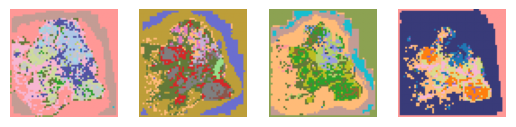

In [160]:
cmap = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c') + sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')
fig, axs = plt.subplots(ncols=len(ds.sections))
for ax, x in zip(axs, cluster_ids):
    x = display_labeled_as_rgb(x, cmap=cmap)
    ax.imshow(x)
    ax.axis('off')

In [77]:
np.unique(cluster_ids, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 array([ 216,  331,   32,  130,  206,  593,   99,  127, 3043,  792, 2913,
         191, 1452,  125,  644,   13,   61,   48,  522,   44,  164,  177,
           7,   18,  214,   17,  123,   13, 2079,    6]))

In [78]:

from sklearn.cluster import AgglomerativeClustering
dist = 50.
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=dist).fit(exp.values)
# clustering = AgglomerativeClustering(n_clusters=10, distance_threshold=None).fit(exp.values)
cluster_to_label = {c:l for c, l in zip(exp.index, clustering.labels_)}
neigh_ids = np.vectorize(cluster_to_label.get)(cluster_ids)
len(np.unique(neigh_ids))

13

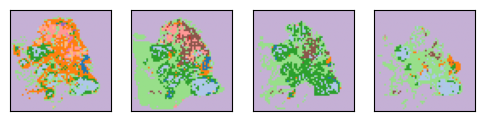

In [79]:
fig, axs = plt.subplots(ncols=neigh_ids.shape[0], figsize=(6, 4))
for i, labeled in enumerate(neigh_ids):
    axs[i].imshow(display_labeled_as_rgb(labeled, cmap=cmap))
    axs[i].set_xticks([])
    axs[i].set_yticks([])

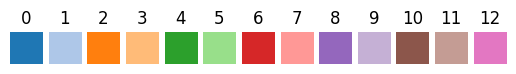

In [80]:
labels = np.unique(neigh_ids)
fig, axs = plt.subplots(ncols=len(labels))
for n, l in enumerate(labels):
    axs[n].imshow(rearrange(np.asarray(cmap[l]), 'n -> 1 1 n'))
    axs[n].axis('off')
    axs[n].set_title(str(l))
    

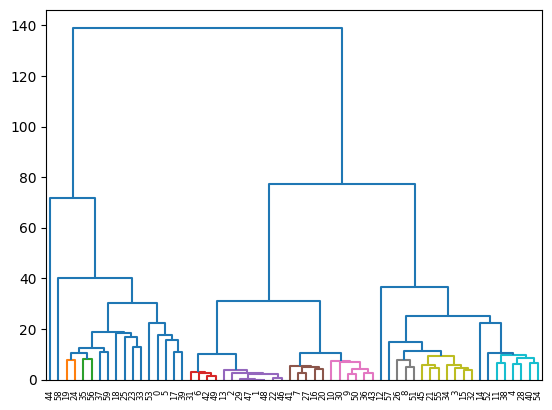

In [150]:
import scipy.cluster.hierarchy as shc
links = shc.linkage(exp.values, method ='ward')
dendrogram = shc.dendrogram((links), color_threshold=dist, labels=exp.index.to_list())